# Should the company increase the price to \\$ 59 from \\$39?

## Out line of the problem
- ### VP of the product want to increase the sales by increasing the price of the software.

- ### Actionable insight for increasing conversion rate and (sales?)

## Approach

- ### Check if the sales increased by raising the price to \\$59

- ### Check if any user segment behaved differently

- ### Confirm hypothesis by getting confidence intervals for each value using bootstrap

## Summary
- ### Overall, increasing the price to \\$59 decreased the conversion rate but significantly increased the sales.

- ### Sales from "mobile" customers signficantly increased. Sales from "web" customers increased but the confidence interval was very close to 1 for sales ratio.

- ### Sales increased significantly for "iOS" and "mac" users, but "linux" users did not buy higher priced software.

- ### Users with "friend referral" has higher conversion rate.

- ### Customers coming from "ads-google" and "seo-google" has higher sales during the test.

- ### Customers coming from "seo-bing" and "seo-yahoo" has lower sales during the test, but need more data to determine it's significance.

- ### Sales for customers in the "east" increased significantly for the test.

- ### Sales for customers in the "south" did not significantly increase for the test.

## Relevant analyses

In [1]:
#Import necessary packages

import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sb
color = sb.color_palette()
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Read in the data: two tables.

In [2]:
#Read the test_results.csv
current_path = os.getcwd()
file = '/datasets/Cost/test_results.csv'
test_results = pd.read_csv(current_path + file)

test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [3]:
#Read in the user data
file = '/datasets/Cost/user_table.csv'
user = pd.read_csv(current_path + file)

user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


### Merge dataframe so we can find where each user lives

In [136]:
test_results_user = pd.merge(test_results, user, on = 'user_id', how='left')

test_results_user.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


### First, group by test and find if the coversion rate is significantly different.

Text(0.5, 0, 'test')

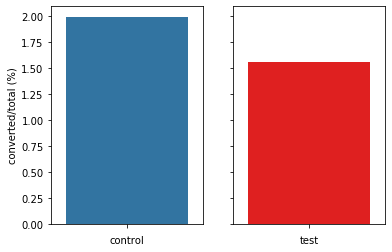

In [140]:
#Group by 'test'
test_control_group = test_results_user.groupby('test') 

#test group got $59 price, control $39
test_group = test_control_group.get_group(1) 
control_group = test_control_group.get_group(0)

test_rate = sum(test_group['converted'])/test_group.shape[0]

control_rate = sum(control_group['converted'])/control_group.shape[0]

#plot the control rate and the test rate
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#fig.suptitle('Current and target turnover rate')
sb.barplot(control_rate*100, orient = 'v', ax =ax1)
ax1.set_ylabel('converted/total (%)')
ax1.set_xlabel('control')
#ax1.set_ylim((0,10)) 
sb.barplot(test_rate*100, orient = 'v', color = 'red', ax = ax2)
ax2.set_xlabel('test')


### test sites has lower sales number, but we want to compare the total sales

Text(0, 0.5, 'test sales/control sales')

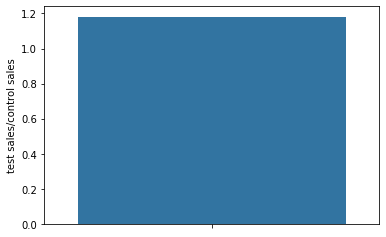

In [143]:
sales_ratio = (59/39 * test_rate)/control_rate
ax1 = sb.barplot(sales_ratio,orient='v')
ax1.set_ylabel('test sales/control sales')

### Use bootstrap to find the confidence interval

In [144]:
# we need to bootstrap to find the confidence interval
control_converted=control_group['converted']
test_converted = test_group['converted']

sales_ratio_boot = np.zeros((1000,1))

for boot_sample in range (1000):
    control_sample = control_converted.sample(frac=1, replace=True)
    test_sample = test_converted.sample(frac=1, replace=True)

    control_rate_boot=sum(control_sample)/control_sample.shape[0]
    test_rate_boot=sum(test_sample)/test_sample.shape[0]
    
    sales_ratio_boot[boot_sample]=(59/39 * test_rate_boot)/control_rate_boot



Text(0.5, 0, 'test sales/control sales')

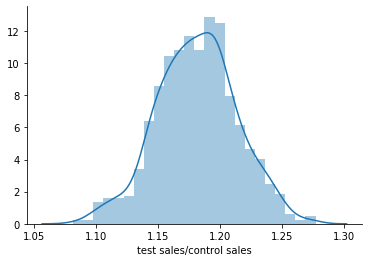

In [146]:
ax1=sb.distplot(sales_ratio_boot)
sb.despine()
ax1.set_xlabel('test sales/control sales')

In [166]:
sales_ratio_df = pd.DataFrame(sales_ratio_boot, columns = ['ratio'])
sales_ratio_df.sort_values(by = ['ratio'],inplace = True)
sales_ratio_df.reset_index(drop=True, inplace = True)
print(sales_ratio_df.iloc[25])
print(sales_ratio_df.iloc[975])

ratio    1.113673
Name: 25, dtype: float64
ratio    1.245304
Name: 975, dtype: float64


### Check if there are any difference in the sales ratio with "device"

In [167]:
#About equal number of mobile and web customers.
device = test_results_user['device']
device_counts = device.value_counts()
device_counts

mobile    186471
web       130329
Name: device, dtype: int64

In [168]:
device_list=test_group.device.unique()
device_list

array(['mobile', 'web'], dtype=object)

In [170]:

#For all device types get the control conversion rate and test conversion rate.
#First column for control, second for the test
device_conversion_rate = np.zeros((device_list.shape[0],2))

test_group_device = test_group.groupby('device') 
control_group_device = control_group.groupby('device') 


n=0
for device in device_list:
    device_group_control=control_group_device.get_group(device) 
    device_conversion_rate[n,0] = sum(device_group_control['converted'])/device_group_control.shape[0]
    
    device_group_test=test_group_device.get_group(device) 
    device_conversion_rate[n,1] = sum(device_group_test['converted'])/device_group_test.shape[0]
    
    n = n+1
device_conversion_rate

array([[0.01987865, 0.01613881],
       [0.01994018, 0.01472454]])

In [171]:
# bootstrap for mobile customers.

device_group_control=control_group_device.get_group('mobile')
device_group_test = test_group_device.get_group('mobile')

control_converted=device_group_control['converted']
test_converted = device_group_test['converted']

sales_ratio_boot_mobile = np.zeros((1000,1))

for boot_sample in range (1000):
    control_sample = control_converted.sample(frac=1, replace=True)
    test_sample = test_converted.sample(frac=1, replace=True)

    control_rate_boot=sum(control_sample)/control_sample.shape[0]
    test_rate_boot=sum(test_sample)/test_sample.shape[0]
    
    sales_ratio_boot_mobile[boot_sample]=(59/39 * test_rate_boot)/control_rate_boot


In [173]:
# bootstrap for web customers.

device_group_control=control_group_device.get_group('web')
device_group_test = test_group_device.get_group('web')

control_converted=device_group_control['converted']
test_converted = device_group_test['converted']

sales_ratio_boot_web = np.zeros((1000,1))

for boot_sample in range (1000):
    control_sample = control_converted.sample(frac=1, replace=True)
    test_sample = test_converted.sample(frac=1, replace=True)

    control_rate_boot=sum(control_sample)/control_sample.shape[0]
    test_rate_boot=sum(test_sample)/test_sample.shape[0]
    
    sales_ratio_boot_web[boot_sample]=(59/39 * test_rate_boot)/control_rate_boot


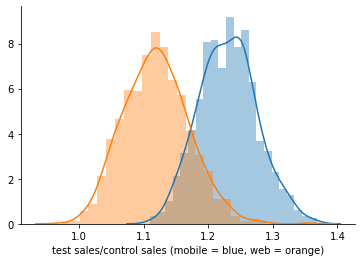

In [176]:
#plot the control rate and the test rate
#fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
#fig.suptitle('Current and target turnover rate')
ax1=sb.distplot(sales_ratio_boot_mobile)
sb.despine()
ax1.set_xlabel('test sales/control sales (mobile = blue, web = orange)')

ax1=sb.distplot(sales_ratio_boot_web)
sb.despine()




In [177]:
sales_ratio_df = pd.DataFrame(sales_ratio_boot_mobile, columns = ['ratio'])
sales_ratio_df.sort_values(by = ['ratio'],inplace = True)
sales_ratio_df.reset_index(drop=True, inplace = True)
print(sales_ratio_df.iloc[25])
print(sales_ratio_df.iloc[975])

ratio    1.146055
Name: 25, dtype: float64
ratio    1.325107
Name: 975, dtype: float64


In [178]:
sales_ratio_df = pd.DataFrame(sales_ratio_boot_web, columns = ['ratio'])
sales_ratio_df.sort_values(by = ['ratio'],inplace = True)
sales_ratio_df.reset_index(drop=True, inplace = True)
print(sales_ratio_df.iloc[25])
print(sales_ratio_df.iloc[975])

ratio    1.03041
Name: 25, dtype: float64
ratio    1.224879
Name: 975, dtype: float64


### Check if "operative system" affect the sales ratio

In [179]:
#Small enough to be able to check each category.
os = test_results_user['operative_system']
os_counts = os.value_counts()
os_counts

windows    100976
iOS         95465
android     74935
mac         25085
other       16204
linux        4135
Name: operative_system, dtype: int64

In [180]:
#Check the list of operative systems
os_list=test_results_user.operative_system.unique()
os_list

array(['iOS', 'android', 'mac', 'windows', 'other', 'linux'], dtype=object)

In [184]:
#Check for different operative systems. 3rd column is the sales ratio
os_conversion_rate = np.zeros((os_list.shape[0],3))

test_group_os = test_group.groupby('operative_system') 
control_group_os = control_group.groupby('operative_system') 


n=0
for os in os_list:
    os_group_control=control_group_os.get_group(os) 
    os_conversion_rate[n,0] = sum(os_group_control['converted'])/os_group_control.shape[0]
    
    os_group_test=test_group_os.get_group(os) 
    os_conversion_rate[n,1] = sum(os_group_test['converted'])/os_group_test.shape[0]
    
    os_conversion_rate[n,2] = (59/39 * os_conversion_rate[n,1])/os_conversion_rate[n,0]
    
    n = n+1

os_conversion_rate

array([[0.02358742, 0.01999405, 1.28235327],
       [0.0163659 , 0.01234799, 1.14141548],
       [0.02547965, 0.02121803, 1.25979229],
       [0.01869761, 0.01398957, 1.13189335],
       [0.01400267, 0.01104101, 1.19284886],
       [0.01540553, 0.        , 0.        ]])

### iOS and Mac users buy more and also pay higher prices. Linux users don't buy higher priced product

In [192]:
data = [{'iOS': 1.28, 'android': 1.14, 'mac': 1.26, 'windows': 1.13, 'other': 1.19, 'linux': 0.0}]
df = pd.DataFrame(data) 


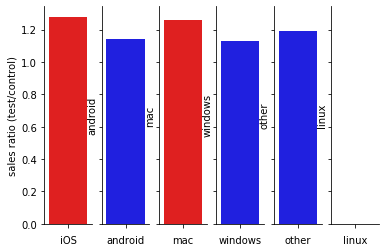

In [191]:
#plot the control rate and the test rate
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, sharey=True)
#fig.suptitle('Current and target turnover rate')
sb.barplot(df['iOS'], orient = 'v', color = 'red', ax =ax1)
ax1.set_ylabel('sales ratio (test/control)')
ax1.set_xlabel('iOS')
#ax1.set_ylim((0,10)) 
sb.barplot(df['android'], orient = 'v', color = 'blue', ax = ax2)
ax2.set_xlabel('android')


sb.barplot(df['mac'], orient = 'v', color = 'red', ax = ax3)
ax3.set_xlabel('mac')

sb.barplot(df['windows'], orient = 'v', color = 'blue', ax = ax4)
ax4.set_xlabel('windows')

sb.barplot(df['other'], orient = 'v', color = 'blue', ax = ax5)
ax5.set_xlabel('other')

sb.barplot(df['linux'], orient = 'v', color = 'blue', ax = ax6)
ax6.set_xlabel('linux')

sb.despine()

In [193]:
# bootstrap for iOS customers.

os_group_control=control_group_os.get_group('iOS')
os_group_test = test_group_os.get_group('iOS')

control_converted=os_group_control['converted']
test_converted = os_group_test['converted']

sales_ratio_boot_ios = np.zeros((1000,1))

for boot_sample in range (1000):
    control_sample = control_converted.sample(frac=1, replace=True)
    test_sample = test_converted.sample(frac=1, replace=True)

    control_rate_boot=sum(control_sample)/control_sample.shape[0]
    test_rate_boot=sum(test_sample)/test_sample.shape[0]
    
    sales_ratio_boot_ios[boot_sample]=(59/39 * test_rate_boot)/control_rate_boot


In [194]:
# bootstrap for mac customers.

os_group_control=control_group_os.get_group('mac')
os_group_test = test_group_os.get_group('mac')

control_converted=os_group_control['converted']
test_converted = os_group_test['converted']

sales_ratio_boot_mac = np.zeros((1000,1))

for boot_sample in range (1000):
    control_sample = control_converted.sample(frac=1, replace=True)
    test_sample = test_converted.sample(frac=1, replace=True)

    control_rate_boot=sum(control_sample)/control_sample.shape[0]
    test_rate_boot=sum(test_sample)/test_sample.shape[0]
    
    sales_ratio_boot_mac[boot_sample]=(59/39 * test_rate_boot)/control_rate_boot


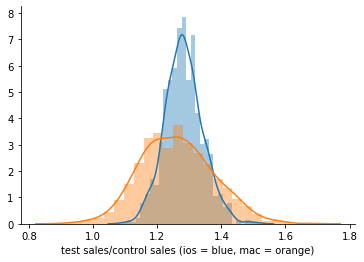

In [195]:
ax1=sb.distplot(sales_ratio_boot_ios)
sb.despine()
ax1.set_xlabel('test sales/control sales (ios = blue, mac = orange)')

ax1=sb.distplot(sales_ratio_boot_mac)
sb.despine()


In [196]:
sales_ratio_df = pd.DataFrame(sales_ratio_boot_ios, columns = ['ratio'])
sales_ratio_df.sort_values(by = ['ratio'],inplace = True)
sales_ratio_df.reset_index(drop=True, inplace = True)
print(sales_ratio_df.iloc[25])
print(sales_ratio_df.iloc[975])

ratio    1.168033
Name: 25, dtype: float64
ratio    1.405765
Name: 975, dtype: float64


In [197]:
sales_ratio_df = pd.DataFrame(sales_ratio_boot_mac, columns = ['ratio'])
sales_ratio_df.sort_values(by = ['ratio'],inplace = True)
sales_ratio_df.reset_index(drop=True, inplace = True)
print(sales_ratio_df.iloc[25])
print(sales_ratio_df.iloc[975])

ratio    1.060504
Name: 25, dtype: float64
ratio    1.488743
Name: 975, dtype: float64


### Check if "source" affect the sales or sales ratio

In [198]:
#Probably worth going through the difference in click rates by source.
source = test_results_user['source']
source_counts = source.value_counts()
source_counts

direct_traffic     60357
ads-google         59379
ads_facebook       53396
ads_other          29876
seo-google         23175
ads-bing           22873
seo_facebook       21205
friend_referral    20695
seo-other           9260
ads-yahoo           7583
seo-yahoo           6848
seo-bing            2153
Name: source, dtype: int64

In [199]:
#list of sources in the order
source_list=test_results_user.source.unique()
source_list

array(['ads_facebook', 'seo-google', 'ads-bing', 'direct_traffic',
       'ads-google', 'seo_facebook', 'friend_referral', 'ads_other',
       'ads-yahoo', 'seo-yahoo', 'seo-bing', 'seo-other'], dtype=object)

In [201]:
source_conversion_rate = np.zeros((source_list.shape[0],3))

test_group_source = test_group.groupby('source') 
control_group_source = control_group.groupby('source') 


n=0
for source in source_list:
    source_group_control=control_group_source.get_group(source) 
    source_conversion_rate[n,0] = sum(source_group_control['converted'])/source_group_control.shape[0]
    
    source_group_test=test_group_source.get_group(source) 
    source_conversion_rate[n,1] = sum(source_group_test['converted'])/source_group_test.shape[0]
    
    source_conversion_rate[n,2] = (59/39 * source_conversion_rate[n,1])/source_conversion_rate[n,0]
   
    n = n+1

source_conversion_rate

array([[0.02366638, 0.016842  , 1.07658687],
       [0.01754734, 0.01597919, 1.37762417],
       [0.01334794, 0.00955954, 1.08345297],
       [0.01354524, 0.01009353, 1.12731068],
       [0.02255441, 0.01961422, 1.31560988],
       [0.01744488, 0.01357642, 1.17734708],
       [0.04172059, 0.03346561, 1.21348846],
       [0.01540137, 0.01246224, 1.22412012],
       [0.01681196, 0.01121157, 1.00887124],
       [0.01948201, 0.01046278, 0.81245749],
       [0.02998501, 0.01343101, 0.67762907],
       [0.01749024, 0.01245921, 1.07766126]])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

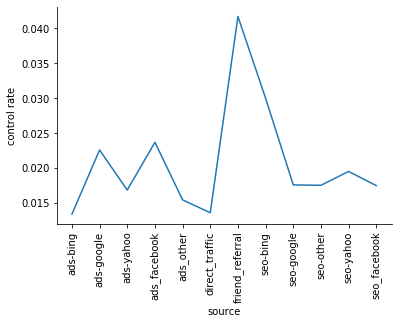

In [210]:
# intialise data of lists. 
data2 = {'control rate':source_conversion_rate[:,0], 'sales ratio':source_conversion_rate[:,2],'source': source_list} 
  
# Create DataFrame 
df2 = pd.DataFrame(data2) 
sb.lineplot(x = df2['source'], y = df2['control rate'], markers = True)
sb.despine()
plt.xticks(rotation = 90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

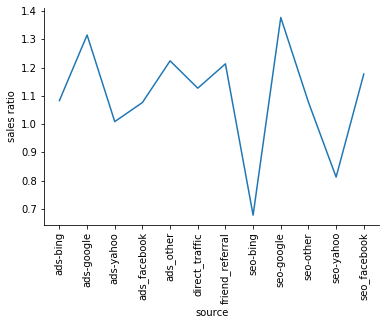

In [211]:
sb.lineplot(x = df2['source'], y = df2['sales ratio'], markers = True)
sb.despine()
plt.xticks(rotation = 90)

In [212]:
# bootstrap for ads-google customers.

source_group_control=control_group_source.get_group('ads-google')
source_group_test = test_group_source.get_group('ads-google')

control_converted=source_group_control['converted']
test_converted = source_group_test['converted']

sales_ratio_boot_adsgoogle = np.zeros((1000,1))

for boot_sample in range (1000):
    control_sample = control_converted.sample(frac=1, replace=True)
    test_sample = test_converted.sample(frac=1, replace=True)

    control_rate_boot=sum(control_sample)/control_sample.shape[0]
    test_rate_boot=sum(test_sample)/test_sample.shape[0]
    
    sales_ratio_boot_adsgoogle[boot_sample]=(59/39 * test_rate_boot)/control_rate_boot


In [213]:
# bootstrap for seo-google customers.

source_group_control=control_group_source.get_group('seo-google')
source_group_test = test_group_source.get_group('seo-google')

control_converted=source_group_control['converted']
test_converted = source_group_test['converted']

sales_ratio_boot_seogoogle = np.zeros((1000,1))

for boot_sample in range (1000):
    control_sample = control_converted.sample(frac=1, replace=True)
    test_sample = test_converted.sample(frac=1, replace=True)

    control_rate_boot=sum(control_sample)/control_sample.shape[0]
    test_rate_boot=sum(test_sample)/test_sample.shape[0]
    
    sales_ratio_boot_seogoogle[boot_sample]=(59/39 * test_rate_boot)/control_rate_boot


In [214]:
# bootstrap for seo-bing customers.

source_group_control=control_group_source.get_group('seo-bing')
source_group_test = test_group_source.get_group('seo-bing')

control_converted=source_group_control['converted']
test_converted = source_group_test['converted']

sales_ratio_boot_seobing = np.zeros((1000,1))

for boot_sample in range (1000):
    control_sample = control_converted.sample(frac=1, replace=True)
    test_sample = test_converted.sample(frac=1, replace=True)

    control_rate_boot=sum(control_sample)/control_sample.shape[0]
    test_rate_boot=sum(test_sample)/test_sample.shape[0]
    
    sales_ratio_boot_seobing[boot_sample]=(59/39 * test_rate_boot)/control_rate_boot


In [215]:
# bootstrap for seo-yahoo customers.

source_group_control=control_group_source.get_group('seo-yahoo')
source_group_test = test_group_source.get_group('seo-yahoo')

control_converted=source_group_control['converted']
test_converted = source_group_test['converted']

sales_ratio_boot_seoyahoo = np.zeros((1000,1))

for boot_sample in range (1000):
    control_sample = control_converted.sample(frac=1, replace=True)
    test_sample = test_converted.sample(frac=1, replace=True)

    control_rate_boot=sum(control_sample)/control_sample.shape[0]
    test_rate_boot=sum(test_sample)/test_sample.shape[0]
    
    sales_ratio_boot_seoyahoo[boot_sample]=(59/39 * test_rate_boot)/control_rate_boot


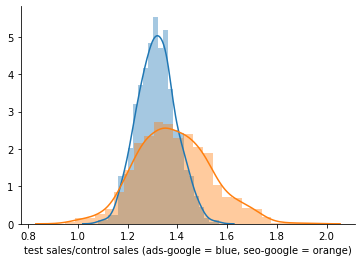

In [216]:
ax1=sb.distplot(sales_ratio_boot_adsgoogle)
sb.despine()
ax1.set_xlabel('test sales/control sales (ads-google = blue, seo-google = orange)')

ax1=sb.distplot(sales_ratio_boot_seogoogle)
sb.despine()


In [217]:
sales_ratio_df = pd.DataFrame(sales_ratio_boot_adsgoogle, columns = ['ratio'])
sales_ratio_df.sort_values(by = ['ratio'],inplace = True)
sales_ratio_df.reset_index(drop=True, inplace = True)
print(sales_ratio_df.iloc[25])
print(sales_ratio_df.iloc[975])

ratio    1.172344
Name: 25, dtype: float64
ratio    1.476243
Name: 975, dtype: float64


In [218]:
sales_ratio_df = pd.DataFrame(sales_ratio_boot_seogoogle, columns = ['ratio'])
sales_ratio_df.sort_values(by = ['ratio'],inplace = True)
sales_ratio_df.reset_index(drop=True, inplace = True)
print(sales_ratio_df.iloc[25])
print(sales_ratio_df.iloc[975])

ratio    1.114174
Name: 25, dtype: float64
ratio    1.702902
Name: 975, dtype: float64


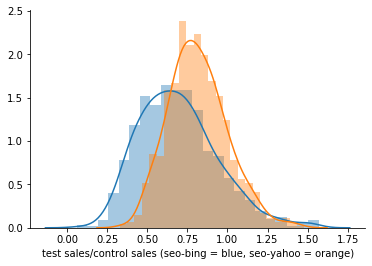

In [219]:
ax1=sb.distplot(sales_ratio_boot_seobing)
sb.despine()
ax1.set_xlabel('test sales/control sales (seo-bing = blue, seo-yahoo = orange)')

ax1=sb.distplot(sales_ratio_boot_seoyahoo)
sb.despine()

In [220]:
sales_ratio_df = pd.DataFrame(sales_ratio_boot_seobing, columns = ['ratio'])
sales_ratio_df.sort_values(by = ['ratio'],inplace = True)
sales_ratio_df.reset_index(drop=True, inplace = True)
print(sales_ratio_df.iloc[25])
print(sales_ratio_df.iloc[975])

ratio    0.295693
Name: 25, dtype: float64
ratio    1.263644
Name: 975, dtype: float64


In [221]:
sales_ratio_df = pd.DataFrame(sales_ratio_boot_seoyahoo, columns = ['ratio'])
sales_ratio_df.sort_values(by = ['ratio'],inplace = True)
sales_ratio_df.reset_index(drop=True, inplace = True)
print(sales_ratio_df.iloc[25])
print(sales_ratio_df.iloc[975])

ratio    0.491872
Name: 25, dtype: float64
ratio    1.220375
Name: 975, dtype: float64


### Check if cities affect sales or sales ratio

In [222]:
#Some rows do not have city info. Drop these rows.
test_group2 = test_group.dropna()
control_group2 = control_group.dropna()


In [223]:
#probably better to make a mask and then use those value to calculate 4 different values each.
#Going through loop takes too much time.
region_conversion_rate = np.zeros((4,3))

test_east = (test_group2['long'] >= -85)
control_east = (control_group2['long'] >= -85)

test_west = (test_group2['long']<= -110)
control_west = (control_group2['long']<= -110)

test_north = (test_group2['long']<-85) & (test_group2['long']> -110) &(test_group2['lat']>=36)
control_north = (control_group2['long']<-85) & (control_group2['long']> -110) &(control_group2['lat']>=36)

test_south = (test_group2['long']<-85) & (test_group2['long']> -110) &(test_group2['lat']<36)
control_south = (control_group2['long']<-85) & (control_group2['long']> -110) &(control_group2['lat']<36)

test_east_data = test_group2.loc[test_east]
control_east_data = control_group2.loc[control_east]

test_west_data = test_group2.loc[test_west]
control_west_data = control_group2.loc[control_west]

test_north_data = test_group2.loc[test_north]
control_north_data = control_group2.loc[control_north]

test_south_data = test_group2.loc[test_south]
control_south_data = control_group2.loc[control_south]

region_conversion_rate[0,0] = sum(control_east_data['converted'])/control_east_data.shape[0]
region_conversion_rate[0,1] = sum(test_east_data['converted'])/test_east_data.shape[0]
region_conversion_rate[0,2] = (59/39 * region_conversion_rate[0,1])/region_conversion_rate[0,0]
    
region_conversion_rate[1,0] = sum(control_west_data['converted'])/control_west_data.shape[0]
region_conversion_rate[1,1] = sum(test_west_data['converted'])/test_west_data.shape[0]
region_conversion_rate[1,2] = (59/39 * region_conversion_rate[1,1])/region_conversion_rate[1,0]


region_conversion_rate[2,0] = sum(control_north_data['converted'])/control_north_data.shape[0]
region_conversion_rate[2,1] = sum(test_north_data['converted'])/test_north_data.shape[0]
region_conversion_rate[2,2] = (59/39 * region_conversion_rate[2,1])/region_conversion_rate[2,0]


region_conversion_rate[3,0] = sum(control_south_data['converted'])/control_south_data.shape[0]
region_conversion_rate[3,1] = sum(test_south_data['converted'])/test_south_data.shape[0]
region_conversion_rate[3,2] = (59/39 * region_conversion_rate[3,1])/region_conversion_rate[3,0]



region_conversion_rate

array([[0.01949365, 0.01605996, 1.24634604],
       [0.01977951, 0.01531328, 1.17122378],
       [0.01896082, 0.01440606, 1.14941098],
       [0.02132334, 0.01510248, 1.07147093]])

In [224]:
#Check if East and South is significnatly different or not.
# bootstrap for customers in the East

control_converted=control_east_data['converted']
test_converted = test_east_data['converted']

sales_ratio_boot_east = np.zeros((1000,1))

for boot_sample in range (1000):
    control_sample = control_converted.sample(frac=1, replace=True)
    test_sample = test_converted.sample(frac=1, replace=True)

    control_rate_boot=sum(control_sample)/control_sample.shape[0]
    test_rate_boot=sum(test_sample)/test_sample.shape[0]
    
    sales_ratio_boot_east[boot_sample]=(59/39 * test_rate_boot)/control_rate_boot


In [225]:
# bootstrap for customers in the South

control_converted=control_south_data['converted']
test_converted = test_south_data['converted']

sales_ratio_boot_south = np.zeros((1000,1))

for boot_sample in range (1000):
    control_sample = control_converted.sample(frac=1, replace=True)
    test_sample = test_converted.sample(frac=1, replace=True)

    control_rate_boot=sum(control_sample)/control_sample.shape[0]
    test_rate_boot=sum(test_sample)/test_sample.shape[0]
    
    sales_ratio_boot_south[boot_sample]=(59/39 * test_rate_boot)/control_rate_boot


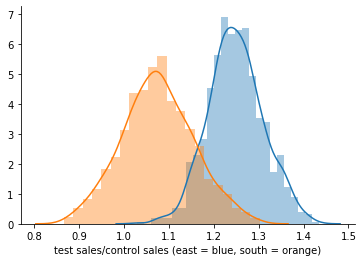

In [226]:
ax1=sb.distplot(sales_ratio_boot_east)
sb.despine()
ax1.set_xlabel('test sales/control sales (east = blue, south = orange)')

ax1=sb.distplot(sales_ratio_boot_south)
sb.despine()

In [227]:
sales_ratio_df = pd.DataFrame(sales_ratio_boot_east, columns = ['ratio'])
sales_ratio_df.sort_values(by = ['ratio'],inplace = True)
sales_ratio_df.reset_index(drop=True, inplace = True)
print(sales_ratio_df.iloc[25])
print(sales_ratio_df.iloc[975])

ratio    1.137808
Name: 25, dtype: float64
ratio    1.373701
Name: 975, dtype: float64


In [228]:
sales_ratio_df = pd.DataFrame(sales_ratio_boot_south, columns = ['ratio'])
sales_ratio_df.sort_values(by = ['ratio'],inplace = True)
sales_ratio_df.reset_index(drop=True, inplace = True)
print(sales_ratio_df.iloc[25])
print(sales_ratio_df.iloc[975])

ratio    0.918726
Name: 25, dtype: float64
ratio    1.238606
Name: 975, dtype: float64


## Results

- ### Overall, increasing the price to \\$59 decreased the conversion rate but significantly increased the sales. However, this effect depends on the type of customers.

- ### Sales from "mobile" customers signficantly increased. Sales from "web" customers increased but the confidence interval was very close to 1 for sales ratio.

- ### Sales increased significantly for "iOS" and "mac" users, but "linux" users did not buy higher priced software.

- ### Users with "friend referral" has higher conversion rate.

- ### Customers coming from "ads-google" and "seo-google" has higher sales during the test.

- ### Customers coming from "seo-bing" and "seo-yahoo" has lower sales during the test, but need more data to determine it's significance.

- ### Sales for customers in the "east" increased significantly for the test.

- ### Sales for customers in the "south" did not significantly increase for the test.

## Future directions

- ### Check if the effect changes with time